# Ignorar

In [1]:
#hide
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [2]:
#hide
# from fastbook import *

# Guardar en Google Drive

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# Tabla de contenidos

- [1 - Librerías](#lib)
- [2 - Paths para proyecto](#path)
- [3 - Metadata](#meta)
- [4 - Carga de imágenes y metadata](#carga)
- [5 - Preprocesamieto de las imágenes](#prepro)
- [6 - Train/Test split](#traintest)
- [7 - Modelo](#model)

<a name='lib'></a>
## Librerías

In [1]:
from fastai.vision.all import *
from utils_ATSIA import *

import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

<a name='path'></a>
## Paths para proyecto

In [3]:
organos = ["AmpollaRectal", "Branquias", "Hepatopancreas", "Intestino", "Uropodo"]
grados = ["G0", "G1", "G2", "G3", "G4"]

#Necesitamos la cantidad de caracteres que cada nomenclatura tiene para cada órgano
organo_len = {"AmpollaRectal" : 10, "Branquias" : 25, "Hepatopancreas" : 27, "Intestino" : 27, "Uropodo" :4}

In [4]:
main_path = Path(os.getcwd()) #Cuando estemos en local
# main_path = "/content/drive/MyDrive/ATSIA" #Cuando usamos Google Drive
path = {}
path["data"] = {}
path["img"] = {}
path["metadata"] = {}

for organo in organos:
    path["data"][organo] = os.path.join(main_path, "data", organo, f"X_{organo}.npy")
    path["img"][organo] = os.path.join(main_path, "img", organo)
    path["metadata"][organo] = os.path.join(main_path, "metadata", organo, f"metadata_{organo}.csv")

In [5]:
#Por el momento vamos a utilizar solo el órgano Hepatopancreas
organo = "Hepatopancreas"

In [6]:
# SIZE = 200

<a name='meta'></a>
## Metada

In [7]:
metadata = get_metadata(path = path["img"][organo], organo = organo, organo_len = organo_len)
metadata.to_csv(path_or_buf = path["metadata"][organo], index=False)
metadata

,img_name,labels
0,DT_G1-DC_G1-L_040-M_G0-N_G0.png,DT_G1 DC_G1 L_040 M_G0 N_G0
1,DT_G0-DC_G1-L_060-M_G0-N_G0.png,DT_G0 DC_G1 L_060 M_G0 N_G0
2,DT_G1-DC_G0-L_075-M_G1-N_G0.png,DT_G1 DC_G0 L_075 M_G1 N_G0
3,DT_G1-DC_G2-L_080-M_G0-N_G0.png,DT_G1 DC_G2 L_080 M_G0 N_G0
4,DT_G3-DC_G0-L_060-M_G0-N_G1.png,DT_G3 DC_G0 L_060 M_G0 N_G1
...,...,...
603,DT_G0-DC_G3-L_040-M_G2-N_G0.png,DT_G0 DC_G3 L_040 M_G2 N_G0
604,DT_G0-DC_G0-L_070-M_G0-N_G0 (7).png,DT_G0 DC_G0 L_070 M_G0 N_G0
605,DT_G1-DC_G0-L_060-M_G1-N_G0.png,DT_G1 DC_G0 L_060 M_G1 N_G0
606,DT_G1-DC_G1-L_050-M_G0-N_G3.png,DT_G1 DC_G1 L_050 M_G0 N_G3


<a name='carga'></a> 
## Carga de imágenes y metadata 

In [8]:
metadata_csv = pd.read_csv(path["metadata"][organo], sep = ",")
metadata_csv.sample(3)

,img_name,labels
109,DT_G4-DC_G1-L_070-M_G1-N_G0.png,DT_G4 DC_G1 L_070 M_G1 N_G0
10,DT_G2-DC_G2-L_060-M_G1-N_G3 (2).png,DT_G2 DC_G2 L_060 M_G1 N_G3
184,DT_G0-DC_G0-L_085-M_G1-N_G0 (2).png,DT_G0 DC_G0 L_085 M_G1 N_G0


### Constructing a DataBlock

In [26]:
# # check for mislabelled data
# b = []

# for i,v in enumerate(metadata_csv["labels"]):
#     a = v.split(" ")
#     for val in a:
#         if val not in b:
#             b.append(val)
#             if val == "N_G0.":
#                 print(v)
# b

In [7]:
img = PILImage(PILImage.create("TEST_IMAGE.png").resize((600,400)))
timg = TensorImage(array(img)).permute(2,0,1).float()/255.
def _batch_ex(bs): return TensorImage(timg[None].expand(bs, *timg.shape).clone())

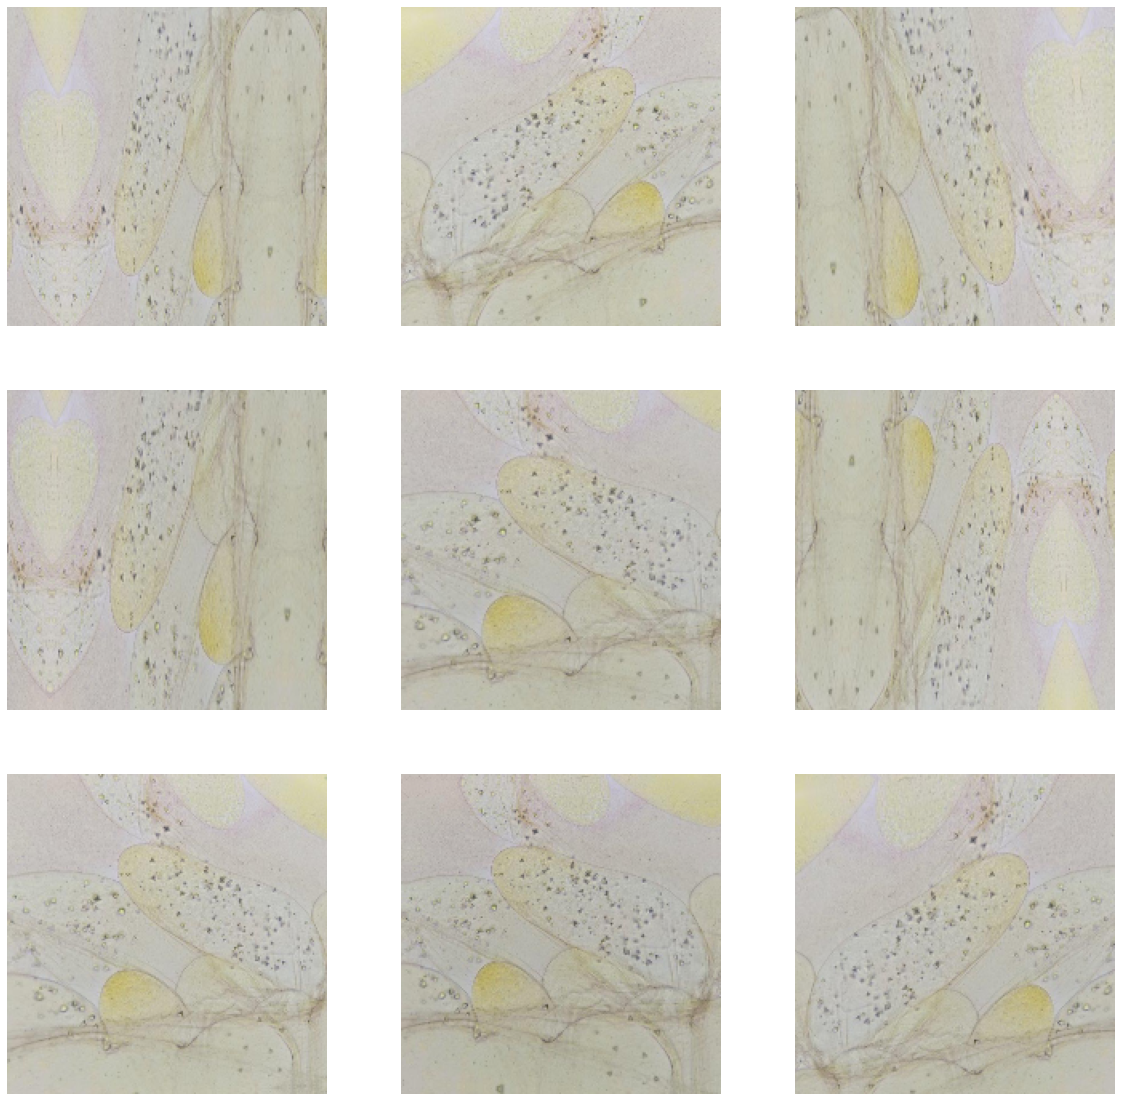

In [9]:
tfms = aug_transforms(mult=1.0, 
                      do_flip=True, 
                      flip_vert=True, 
                      max_rotate=10.0, 
                      min_zoom=1.0, 
                      max_zoom=1.2, 
                      max_lighting=0.1, 
                      max_warp=0.1, 
                      p_affine=0.75, 
                      p_lighting=0.75, 
                      xtra_tfms=None, 
                      size=(200,200), 
                      mode='bilinear', 
                      pad_mode='reflection', 
                      align_corners=True, 
                      batch=False, 
                      min_scale=1.0)
y = _batch_ex(9)
for t in tfms: y = t(y, split_idx=0)
_,axs = plt.subplots(3,3, figsize=(20,20))
for i,ax in enumerate(axs.flatten()): show_image(y[i], ctx=ax)

In [9]:
def get_x(r): return Path(path["img"][organo], r['img_name'])
def get_y(r): return r['labels'].split(" ")


dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, 
                   get_y = get_y, 
                   item_tfms = Resize(500),
                   splitter = RandomSplitter(valid_pct=0.2, seed=42),
                   batch_tfms =[*aug_transforms(mult=1.0,
                                              do_flip=True,
                                              flip_vert=True,
                                              max_rotate=10.0, 
                                              min_zoom=1.0, 
                                              max_zoom=1.2, 
                                              max_lighting=0.1, 
                                              max_warp=0.1, 
                                              p_affine=0.75, 
                                              p_lighting=0.75, 
#                                               size=(200,200), 
                                              mode='bilinear', 
                                              pad_mode='reflection', 
                                              align_corners=True, 
                                              batch=False, 
                                              min_scale=1.0),Normalize.from_stats(*imagenet_stats)]
                   )
dsets = dblock.datasets(metadata_csv)
dsets.train[0]
# dsets.valid[0]

(PILImage mode=RGB size=3096x3096,
 TensorMultiCategory([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.]))

In [10]:
idxs = torch.where(dsets.train[0][1] == 1.)[0]
dsets.train.vocab[idxs]

(#5) ['DC_G1','DT_G1','L_080','M_G1','N_G0']

And now we can display a sample of our data:

In [12]:
dls = dblock.dataloaders(metadata_csv, bs=16)

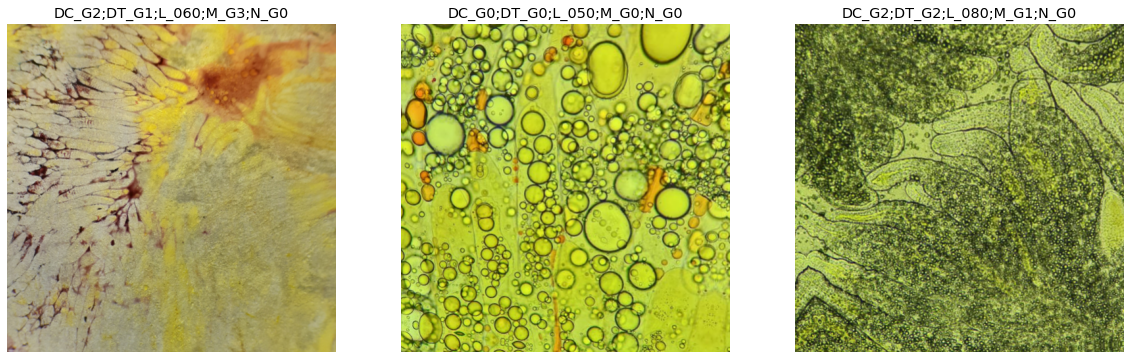

In [13]:
dls.show_batch(nrows=1, ncols=3, figsize=(20,10))

In [14]:
dls.valid.items

,img_name,labels
262,DT_G1-DC_G1-L_090-M_G0-N_G0 (12).png,DT_G1 DC_G1 L_090 M_G0 N_G0
14,DT_G1-DC_G1-L_090-M_G0-N_G0 (32).png,DT_G1 DC_G1 L_090 M_G0 N_G0
96,DT_G2-DC_G0-L_070-M_G0-N_G0.png,DT_G2 DC_G0 L_070 M_G0 N_G0
292,DT_G2-DC_G2-L_060-M_G1-N_G4.png,DT_G2 DC_G2 L_060 M_G1 N_G4
570,DT_G3-DC_G1-L_040-M_G2-N_G1.png,DT_G3 DC_G1 L_040 M_G2 N_G1
...,...,...
364,DT_G3-DC_G3-L_020-M_G0-N_G1.png,DT_G3 DC_G3 L_020 M_G0 N_G1
242,DT_G1-DC_G0-L_060-M_G0-N_G0 (3).png,DT_G1 DC_G0 L_060 M_G0 N_G0
209,DT_G2-DC_G4-L_070-M_G1-N_G0.png,DT_G2 DC_G4 L_070 M_G1 N_G0
356,DT_G0-DC_G0-L_080-M_G0-N_G1.png,DT_G0 DC_G0 L_080 M_G0 N_G1


### Binary Cross-Entropy

In [15]:
def atsia_acc(preds, targs):
    
    acc = pd.DataFrame(np.zeros((len(preds), 5)), columns= ["acc_dc","acc_dt", "acc_l", "acc_m", "acc_n" ])

    for i in range(0, len(preds)):
        
        cat1_preds = preds[i][:5]
        cat1_targs = targs[i][:5]

        cat2_preds = preds[i][5:10]
        cat2_targs = targs[i][5:10]

        cat3_preds = preds[i][10:27]
        cat3_targs = targs[i][10:27]

        cat4_preds = preds[i][27:32]
        cat4_targs = targs[i][27:32]

        cat5_preds = preds[i][32:]
        cat5_targs = targs[i][32:]
        
        if torch.eq(cat1_preds.argmax(), cat1_targs.argmax()):
            acc["acc_dc"][i] = 1

        if torch.eq(cat2_preds.argmax(), cat2_targs.argmax()):
            acc["acc_dt"][i] = 1

        if torch.eq(cat3_preds.argmax(), cat3_targs.argmax()):
            acc["acc_l"][i] = 1 

        if torch.eq(cat4_preds.argmax(), cat4_targs.argmax()):
            acc["acc_m"][i] = 1

        if torch.eq(cat5_preds.argmax(), cat5_targs.argmax()):
            acc["acc_n"][i] = 1
        
    return acc.describe().loc["mean"].mean()
    

In [16]:
learn = cnn_learner(dls, resnet101, metrics = atsia_acc)#partial(accuracy_multi, thresh=0.7)) 
#usamos partial para indicar un nuevo parametros a la función accuracy_multi que tiene como default thresh = 0.5
#Usa la funcion de perdida de BCEWithLogitsLoss automáticamente al ser multi-label classification

In [17]:
dls.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [193]:
# x, y = dls.train.one_batch()
# activs = learn.model(x)
# activs.shape

SuggestedLRs(valley=0.0020892962347716093)

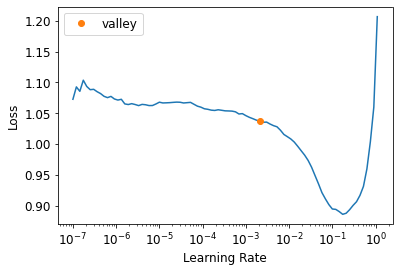

In [23]:
learn.lr_find()

In [19]:
learn.fine_tune(1, base_lr=3e-3, freeze_epochs=1)

epoch,train_loss,valid_loss,atsia_acc,time
0,0.982011,0.837709,0.312397,01:03


epoch,train_loss,valid_loss,atsia_acc,time
0,0.785200,0.693331,0.441322,01:09


In [30]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,atsia_acc,time
0,0.722671,2.857867,0.295868,01:06
1,0.681306,2.568305,0.363636,01:08
2,0.615678,0.647406,0.418182,01:08
3,0.561022,0.423312,0.451240,01:09
4,0.518036,0.391367,0.464463,01:08


In [31]:
learn.metrics = atsia_acc
learn.validate()

(#2) [0.3913666903972626,0.4644628099173554]

If you pick a threshold that's too high, you'll only be selecting the objects for which your model is very confident:

We can find the best threshold by trying a few levels and seeing what works best. This is much faster if we just grab the predictions once:

In [32]:
preds,targs = learn.get_preds()

Then we can call the metric directly. Note that by default `get_preds` applies the output activation function (sigmoid, in this case) for us, so we'll need to tell `accuracy_multi` to not apply it:

In [33]:
preds[0]

TensorBase([0.2054, 0.4081, 0.4385, 0.3330, 0.1669, 0.1862, 0.3754, 0.3524, 0.3482, 0.2945, 0.2500, 0.2502, 0.2839, 0.2201, 0.2158, 0.2821, 0.2307, 0.2206, 0.2425, 0.2230, 0.3107, 0.2163, 0.3910, 0.2392,
        0.2481, 0.1999, 0.1964, 0.6538, 0.2646, 0.2495, 0.1833, 0.2593, 0.7221, 0.2366, 0.2278, 0.2252, 0.2246])

In [34]:
targs[0]

TensorMultiCategory([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

We didn't specify a loss function, which means we're getting whatever fastai chooses as the default. Let's see what it picked for us:

SuggestedLRs(valley=9.120108734350652e-05)

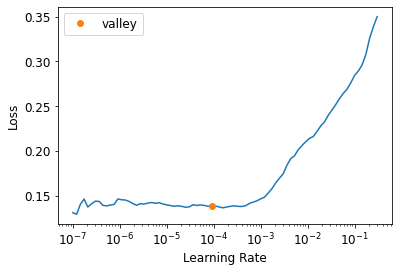

In [107]:
learn.lr_find()

We'll try an LR of 1e-2:

In [110]:
lr = 5e-5
learn.fine_tune(5, lr)

epoch,train_loss,valid_loss,atsia_acc,time
0,0.137261,0.314710,0.532231,01:01


epoch,train_loss,valid_loss,atsia_acc,time
0,0.136959,0.314867,0.527273,01:09
1,0.140312,0.315140,0.530579,01:10
2,0.135101,0.314802,0.528926,01:11
3,0.137750,0.318535,0.525620,01:10
4,0.136154,0.317610,0.522314,01:11


This sounds very accurate! But it's important to take a look at our results with `Learner.show_results`. The left side are the actual (*ground truth*) coordinates and the right side are our model's predictions:

In [20]:
preds.shape

torch.Size([121, 37])

In [135]:
def preds_norm (preds):
    cat = np.array(np.zeros(preds.shape))
    
    for i in range(0, len(preds)-1):
        
        cat1_preds = preds[i][:5]
        
        cat2_preds = preds[i][5:10]

        cat3_preds = preds[i][10:27]

        cat4_preds = preds[i][27:32]

        cat5_preds = preds[i][32:]

        cat1_preds_new = np.zeros(len(cat1_preds))
        cat1_preds_new[cat1_preds.argmax()] = 1
        
        cat2_preds_new = np.zeros((len(cat2_preds)))
        cat2_preds_new[cat2_preds.argmax()] = 1

        cat3_preds_new = np.zeros((len(cat3_preds)))
        cat3_preds_new[cat3_preds.argmax()] = 1

        cat4_preds_new = np.zeros((len(cat4_preds)))
        cat4_preds_new[cat4_preds.argmax()] = 1

        cat5_preds_new = np.zeros((len(cat5_preds)))
        cat5_preds_new[cat5_preds.argmax()] = 1
#         print(i)
        
#         print(cat1_preds_new, cat2_preds_new, cat3_preds_new, cat4_preds_new, cat5_preds_new)
        cat[i] = np.concatenate((cat1_preds_new, cat2_preds_new, cat3_preds_new, cat4_preds_new, cat5_preds_new), axis = 0)
    return cat


In [180]:
preds_norm_1 = preds_norm(preds)
preds_norm_1 = torch.from_numpy(preds_norm_1)
preds_norm_1[0]

tensor([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=torch.float64)

In [143]:
targs[0]

TensorMultiCategory([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [145]:
acc_prueba = atsia_acc(preds_norm_1, targs)
acc_prueba

0.5322314049586776

In [21]:
acc = atsia_acc(preds, targs)
acc

0.3553719008264463

In [181]:
# def preds_norm (preds):
#     cat = np.array(np.zeros(preds.shape))
    
#     for i in range(0, len(preds)-1):
        
#         cat1_preds = preds[i][:5]
        
#         cat2_preds = preds[i][5:10]

#         cat3_preds = preds[i][10:27]

#         cat4_preds = preds[i][27:32]

#         cat5_preds = preds[i][32:]

#         cat1_preds_new = np.zeros(len(cat1_preds))
#         cat1_preds_new[cat1_preds.argmax()] = 1
        
#         cat2_preds_new = np.zeros((len(cat2_preds)))
#         cat2_preds_new[cat2_preds.argmax()] = 1

#         cat3_preds_new = np.zeros((len(cat3_preds)))
#         cat3_preds_new[cat3_preds.argmax()] = 1

#         cat4_preds_new = np.zeros((len(cat4_preds)))
#         cat4_preds_new[cat4_preds.argmax()] = 1

#         cat5_preds_new = np.zeros((len(cat5_preds)))
#         cat5_preds_new[cat5_preds.argmax()] = 1
# #         print(i)
        
# #         print(cat1_preds_new, cat2_preds_new, cat3_preds_new, cat4_preds_new, cat5_preds_new)
#         cat[i] = np.concatenate((cat1_preds_new, cat2_preds_new, cat3_preds_new, cat4_preds_new, cat5_preds_new), axis = 0)
#     return cat

# def show_results2(ds_idx=1, dl=None, max_n=9, shuffle=True, **kwargs):
#         if dl is None: dl = dls[ds_idx].new(shuffle=shuffle)
#         b = dl.one_batch()
#         _,_,preds = learn.get_preds(dl=[b], with_decoded=True)
#         preds_atsia = preds_norm(preds)
#         preds_atsia = torch.from_numpy(preds_atsia)
#         dls.show_results(b, preds_atsia, max_n=max_n, **kwargs)

In [26]:
preds[0][:5]

TensorBase([0.5585, 0.5412, 0.2241, 0.3715, 0.1886])

In [28]:
targs[0][:5]

TensorMultiCategory([0., 1., 0., 0., 0.])

In [57]:
fnames=get_image_files(path["img"][organo])
learn.predict(fnames[1])

((#4) ['DC_G0','DT_G0','M_G0','N_G0'],
 TensorBase([ True, False, False, False, False,  True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,
          True, False, False, False, False,  True, False, False, False, False]),
 TensorBase([0.6258, 0.3210, 0.1650, 0.1959, 0.2012, 0.5025, 0.3847, 0.2164, 0.2091, 0.2848, 0.2233, 0.2381, 0.2197, 0.2024, 0.2050, 0.2503, 0.2178, 0.1808, 0.2363, 0.2329, 0.2989, 0.2740, 0.2909, 0.2816,
         0.2964, 0.2290, 0.1926, 0.6616, 0.3976, 0.1722, 0.1943, 0.2088, 0.8520, 0.2114, 0.1944, 0.1838, 0.1949]))

In [58]:
fnames[1]

Path('/home/ubuntu/ATSIA/img/Hepatopancreas/DT_G0-DC_G1-L_060-M_G0-N_G0.png')

In [86]:
dls.train.items

,img_name,labels
340,DT_G1-DC_G1-L_080-M_G1-N_G0 (4).png,DT_G1 DC_G1 L_080 M_G1 N_G0
535,DT_G1-DC_G1-L_060-M_G0-N_G0 (2).png,DT_G1 DC_G1 L_060 M_G0 N_G0
23,DT_G4-DC_G4-L_000-M_G4-N_G4.png,DT_G4 DC_G4 L_000 M_G4 N_G4
252,DT_G2-DC_G2-L_060-M_G1-N_G0.png,DT_G2 DC_G2 L_060 M_G1 N_G0
554,DT_G1-DC_G1-L_070-M_G0-N_G0 (2).png,DT_G1 DC_G1 L_070 M_G0 N_G0
...,...,...
320,DT_G3-DC_G1-L_070-M_G0-N_G0 (2).png,DT_G3 DC_G1 L_070 M_G0 N_G0
386,DT_G0-DC_G1-L_060-M_G0-N_G3.png,DT_G0 DC_G1 L_060 M_G0 N_G3
603,DT_G0-DC_G3-L_040-M_G2-N_G0.png,DT_G0 DC_G3 L_040 M_G2 N_G0
474,DT_G2-DC_G1-L_070-M_G2-N_G1.png,DT_G2 DC_G1 L_070 M_G2 N_G1


In [100]:
learn.get_preds??

In [93]:
len(dls.train.one_batch())

2

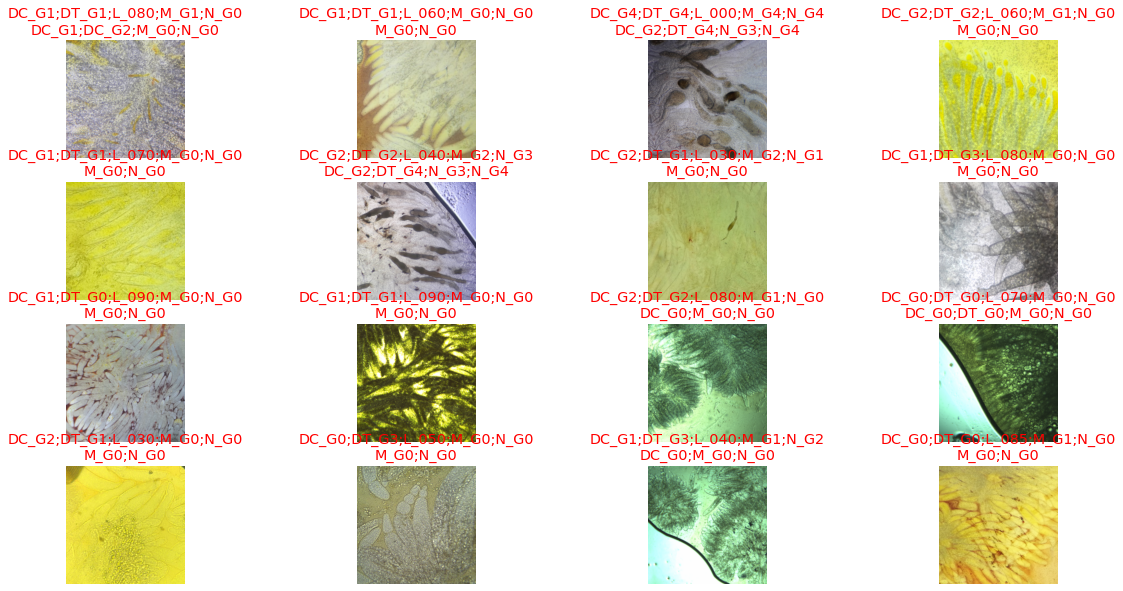

In [87]:
learn.show_results(ds_idx = 0, max_n = 20, figsize = (20,10), shuffle=False)

## Conclusion

In problems that are at first glance completely different (single-label classification, multi-label classification, and regression), we end up using the same model with just different numbers of outputs. The loss function is the one thing that changes, which is why it's important to double-check that you are using the right loss function for your problem.

fastai will automatically try to pick the right one from the data you built, but if you are using pure PyTorch to build your `DataLoader`s, make sure you think hard when you have to decide on your choice of loss function, and remember that you most probably want:

- `nn.CrossEntropyLoss` for single-label classification
- `nn.BCEWithLogitsLoss` for multi-label classification
- `nn.MSELoss` for regression